Example of VAE on MNIST dataset using CNN

The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean=0 and std=1.

# Reference

[1] Kingma, Diederik P., and Max Welling.
"Auto-encoding variational bayes."
https://arxiv.org/abs/1312.6114

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras import layers
from keras import models
from keras import losses
from keras import backend as K

In [3]:
# reparameterization trick
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

image_size = X_train.shape[1]
X_train = np.reshape(X_train, [-1, image_size, image_size, 1])
X_test = np.reshape(X_test, [-1, image_size, image_size, 1])
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

In [5]:
# VAE model = encoder + decoder
# build encoder model
inputs = layers.Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = layers.Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      activation='relu',
                      strides=2,
                      padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = layers.Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = layers.Conv2DTranspose(filters=filters,
                               kernel_size=kernel_size,
                               activation='relu',
                               strides=2,
                               padding='same')(x)
    filters //= 2

outputs = layers.Conv2DTranspose(filters=1,
                                 kernel_size=kernel_size,
                                 activation='sigmoid',
                                 padding='same',
                                 name='decoder_output')(x)

# instantiate decoder model
decoder = models.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = models.Model(inputs, outputs, name='vae')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
_____________________________________

In [6]:
reconstruction_loss = losses.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [7]:
vae.fit(X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, None))
vae.save_weights('vae_cnn_mnist.h5')

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 107us/step - loss: 192.3160 - val_loss: 171.0847
Epoch 2/30
60000/60000 [==============================] - 4s 60us/step - loss: 168.6222 - val_loss: 164.5115
Epoch 3/30
60000/60000 [==============================] - 4s 61us/step - loss: 162.9569 - val_loss: 160.5014
Epoch 4/30
60000/60000 [==============================] - 4s 62us/step - loss: 159.6082 - val_loss: 157.2561
Epoch 5/30
60000/60000 [==============================] - 4s 62us/step - loss: 157.4450 - val_loss: 155.2536
Epoch 6/30
60000/60000 [==============================] - 4s 63us/step - loss: 155.7951 - val_loss: 153.4568
Epoch 7/30
60000/60000 [==============================] - 4s 62us/step - loss: 154.3636 - val_loss: 154.5456
Epoch 8/30
60000/60000 [==============================] - 4s 63us/step - loss: 153.4073 - val_loss: 153.4822
Epoch 9/30
60000/60000 [=====

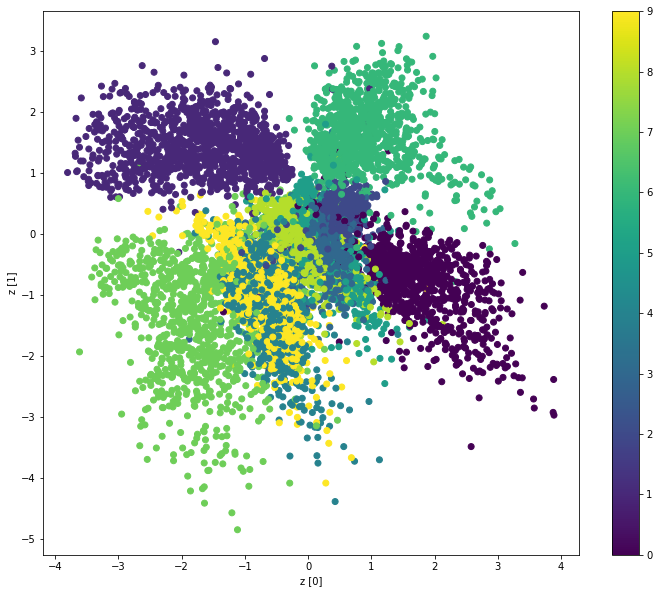

In [8]:
z_mean, _, _ = encoder.predict(X_test,
                               batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z [0]")
plt.ylabel("z [1]")
plt.show()

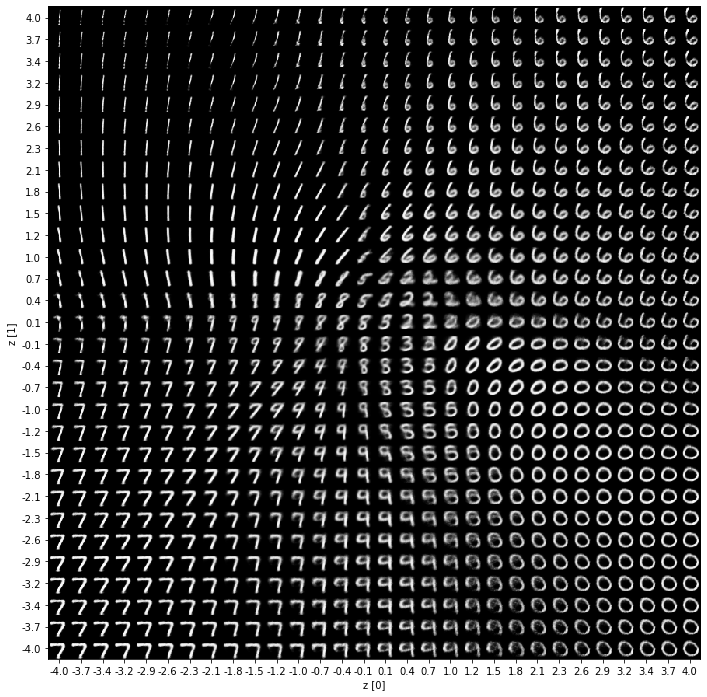

In [9]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(12, 12))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z [0]")
plt.ylabel("z [1]")
plt.imshow(figure, cmap='Greys_r')
plt.show()